In [1]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize
from scipy.stats import linregress
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# All the functions

In [2]:
#define functions

#create function that finds mena
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues < np.random.randint(100, size=(1000,))
    oranges_who_defaulted = true_oranges < np.random.randint(100, size=(1000,))

    blues = true_blues
    oranges = true_oranges
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

## Find a way to create populations

In [3]:
a, mean_a, _ = brownian_population()
b, mean_b, _ = brownian_population()

if mean_a > mean_b:
    blues = np.copy(b)
    oranges = np.copy(a)
else:
    blues = np.copy(a)
    oranges = np.copy(b)
    
true_blues = np.zeros(1)
true_oranges = np.zeros(1)

for i in range(100):
    num_blues = int(blues[i])
    num_oranges = int(oranges[i])
    elements_blues = np.multiply(np.ones(num_blues),i)
    elements_oranges = np.multiply(np.ones(num_oranges), i)
    
    true_blues = np.concatenate((true_blues, elements_blues), axis=0)
    true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)
    
#determine who defaulted
blues_who_defaulted = true_blues.T < np.random.randint(100, size=(1000,))
oranges_who_defaulted = true_oranges.T < np.random.randint(100, size=(1000,))

blues = true_blues.T
oranges = true_oranges.T

## Plot populations

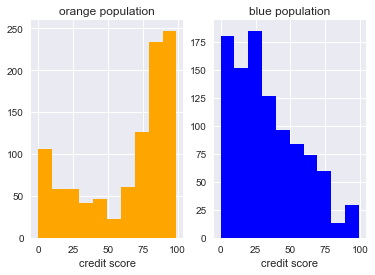

In [4]:
plt.subplot(121)
plt.hist(oranges, bins=10, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=10, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()


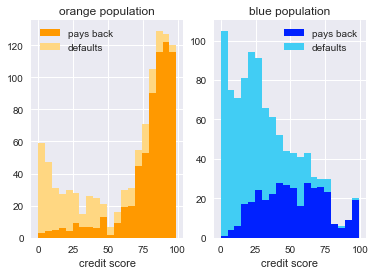

In [5]:
plt.subplot(121)
plt.hist([true_oranges[np.logical_not(oranges_who_defaulted)],true_oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([true_blues[np.logical_not(blues_who_defaulted)],true_blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

## Optimise for the first time

In [6]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  423 $


### With fairness

In [7]:
t= time.time()
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, 
#                     method='SLSQP', 
                    constraints = cons,
                    bounds=bounds, 
                    options = {'eps': 3})


x_fair = solution.x

print(t - time.time())

-3.4385898113250732


In [8]:
print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[25.39815915 65.74982159]
final guess of [25.39815915 65.74982159] got us a profit of  199 $
total credit score change for blues: -216 || total credit score change for oranges: 415


### Without fairness

In [9]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [10]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

final guess of [61.21163781 63.57629373] got us a profit of  491 $
total credit score change for blues: 77 || total credit score change for oranges: 414


# Do this all systematically

## 1. With BOTH!

In [11]:

num_its = 200

profit_eq_opt = np.zeros(num_its)
credit_change_blues_eq_opt = np.zeros(num_its)
credit_change_oranges_eq_opt = np.zeros(num_its)
cutoffs_eq_opt = np.zeros((num_its, 2))

population_log_blues = np.zeros((num_its, 1000))
population_log_oranges = np.zeros((num_its, 1000))

profit_no_fairness = np.zeros(num_its)
credit_change_blues_no_fairness = np.zeros(num_its)
credit_change_oranges_no_fairness = np.zeros(num_its)
cutoffs_no_fairness = np.zeros((num_its, 2))

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50



#impose bounds
a = (0, 100)
bounds = (a, a)

how_long_did_it_take = time.time()

for i in range(num_its):
    t = time.time()
    

    
    blues, oranges, blues_who_defaulted, oranges_who_defaulted, _, _ = create_blues_and_oranges()
    
    
    
    population_log_blues[i] = blues
    population_log_oranges[i] = oranges
    
    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1])
    
    
    
    #optimise bank profit
    to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])
    
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])
    
    solution_fair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3, 'maxiter': 10})

    x_fair = solution_fair.x
    
    cutoffs_eq_opt[i] = x_fair

    profit_eq_opt[i] = -to_optimise(x_fair)
    _, _, credit_change_blues_eq_opt[i] = bank_profit(blues, blues_who_defaulted, x_fair[0])
    _, _, credit_change_oranges_eq_opt[i] = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
    
    solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_unfair.x
    
    profit_no_fairness[i] = -to_optimise(x_unfair)
    _, _, credit_change_blues_no_fairness[i] = bank_profit(blues, blues_who_defaulted, x_unfair[0])
    _, _, credit_change_oranges_no_fairness[i] = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
    
    cutoffs_no_fairness[i] = x_unfair
    
    if (i % 50 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")
    
    print(i)

print("This took long to run,", (time.time() - how_long_did_it_take)/60, "minutes to be exact.")

iteration 0 (which took 5.476757049560547 seconds).
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
iteration 50 (which took 1.2962639331817627 seconds).
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
iteration 100 (which took 1.190561056137085 seconds).
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
iteration 150 (which took 3.2744829654693604 seconds).
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
This took long to run, 8.224514929453532 minutes to be exact.


## Plot distributions of populations under fairness and no fairness constraints

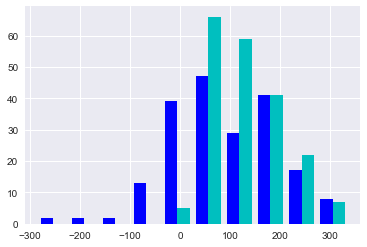

In [12]:
plt.hist((credit_change_blues_eq_opt, credit_change_blues_no_fairness), color=("b", "c"))
plt.show()

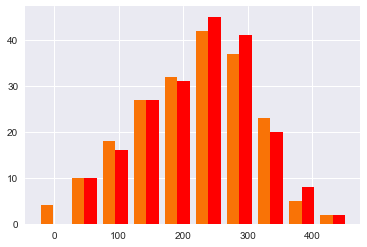

In [13]:
plt.hist((credit_change_oranges_eq_opt, credit_change_oranges_no_fairness), color=("xkcd:orange", "r"))
plt.show()

In [14]:
print("Fairness blues got", sum(credit_change_blues_eq_opt), 
      "whereas unfair blues got", sum(credit_change_blues_no_fairness))

print("Fairness oranges got", sum(credit_change_oranges_eq_opt), 
      "whereas unfair oranges got", sum(credit_change_oranges_no_fairness))

Fairness blues got 17918.0 whereas unfair blues got 25968.0
Fairness oranges got 43330.0 whereas unfair oranges got 44945.0


In [15]:
comparisons_smaller = credit_change_blues_eq_opt < credit_change_blues_no_fairness
comparisons_bigger = credit_change_blues_eq_opt > credit_change_blues_no_fairness
comparisons_equal = np.abs(credit_change_blues_eq_opt - credit_change_blues_no_fairness) < 3

# Generate pretty plots

1. What's the gap between unfair and fair classification
2. What do the distributions look like?
3. How many people default?


### 1. What's the gap between unfair and fair classification

In [16]:
average_blue = np.average(population_log_blues, axis=0)
average_orange = np.average(population_log_oranges, axis=0)
average_distance = average_orange[:200]-average_blue[:200]
population_log_blues.shape

(200, 1000)

In [17]:
frame = np.concatenate((credit_change_blues_eq_opt.reshape(200,1), 
                        credit_change_oranges_eq_opt.reshape(200,1), 
                        credit_change_blues_no_fairness.reshape(200,1), 
                        credit_change_oranges_no_fairness.reshape(200,1)), axis=1)

change_for_blues = np.concatenate((credit_change_blues_eq_opt.reshape(200,1), 
                                   credit_change_blues_no_fairness.reshape(200,1),
                                   average_distance.reshape(200,1)), 
                                  axis=1)

credit_changes_blue = pd.DataFrame(change_for_blues)
credit_changes_blue.columns = ["blue with equal opportunity",
                               "blue with no constraints",
                               "average distance"]


credit_changes = pd.DataFrame(frame)
credit_changes.columns = ["blue with equal opportunity", 
                          "orange with equal opportunity", 
                          "blue with no constraint", 
                          "oranges with no constraint"]

In [18]:
credit_changes_blue["distance"] = credit_changes_blue["blue with no constraints"] - credit_changes_blue["blue with equal opportunity"]

credit_changes_blue = credit_changes_blue.sort_values("distance", ascending=False)

credit_changes_blue["sorted index"] = np.arange(200)
credit_changes_blue.head()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
159,-285.0,48.0,9.650,333.0,0
175,-232.0,55.0,10.245,287.0,1
71,-167.0,90.0,5.350,257.0,2
151,-197.0,35.0,9.380,232.0,3
4,-147.0,36.0,0.215,183.0,4


# HERHEHEHREHRHERE

In [19]:
workblue = np.copy(population_log_blues[168])
workorange = np.copy(population_log_oranges[168])
workblue_defaults = workblue < np.random.randint(100, size=(1000,))
workorange_defaults = workorange < np.random.randint(100, size=(1000,))

In [20]:
#what to optimise
to_optimise = lambda x: total_bank_profit(workblue, workorange, workblue_defaults, 
                                          workorange_defaults, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(workblue, workorange, workblue_defaults, 
                                                      workorange_defaults, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  185 $


### With fairness

In [21]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3, 'maxiter':10})

x_fair = solution.x

print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(workblue, workblue_defaults, x_fair[0])
_, _, oranges_credit_change = bank_profit(workorange, workorange_defaults, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[49.73483549 50.56486948]
final guess of [49.73483549 50.56486948] got us a profit of  191 $
total credit score change for blues: 25 || total credit score change for oranges: 166


In [22]:
print(sum(np.logical_and(workblue > 31.2, np.logical_not(workblue_defaults))), "this is true positive")
print(sum(np.logical_and(workblue > 31.09, workblue_defaults)), "false positive")

print(sum(np.logical_and(workorange > 58.2, np.logical_not(workorange_defaults))), "this is true positive")
print(sum(np.logical_and(workorange > 58.09, workorange_defaults)), "false positive")

363 this is true positive
261 false positive
309 this is true positive
67 false positive


### Without fairness

In [23]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(workblue, workblue_defaults, x_unfair[0])
_, _, oranges_credit_change = bank_profit(workorange, workorange_defaults, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

print(sum(np.logical_and(workblue > x_unfair[0], np.logical_not(workblue_defaults))), "this is true positive")
print(sum(np.logical_and(workblue > x_unfair[0], workblue_defaults)), "false positive")

print(sum(np.logical_and(workorange > x_unfair[1], np.logical_not(workorange_defaults))), "this is true positive")
print(sum(np.logical_and(workorange > x_unfair[1], workorange_defaults)), "false positive")

final guess of [64.6778337  57.14947105] got us a profit of  235 $
total credit score change for blues: 58 || total credit score change for oranges: 177
142 this is true positive
42 false positive
311 this is true positive
67 false positive


In [24]:
loans_b = workblue < x_fair[0]
true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(workblue_defaults))
false_positives_b = np.logical_and(np.logical_not(loans_b), workblue_defaults)


loans_o = workorange < x_fair[1]
true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(workorange_defaults))
false_positives_o = np.logical_and(np.logical_not(loans_o), workorange_defaults)

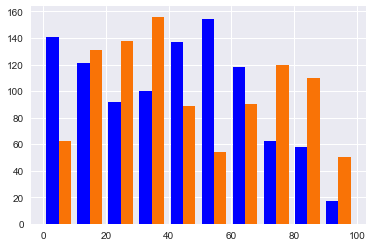

In [25]:
plt.hist([workblue, workorange], color=['b', 'xkcd:orange'])
plt.show()

In [26]:
workblue_fair = np.copy(workblue)
workorange_fair = np.copy(workorange)

workblue_fair[true_positives_b] +=10
workblue_fair[false_positives_b] -=20
workblue_fair[workblue_fair<1] = 1
workblue_fair[workblue_fair>99] = 99

workorange_fair[true_positives_o] +=10
workorange_fair[false_positives_o] -=20
workorange_fair[workorange_fair<1] = 1
workorange_fair[workorange_fair>99] = 99

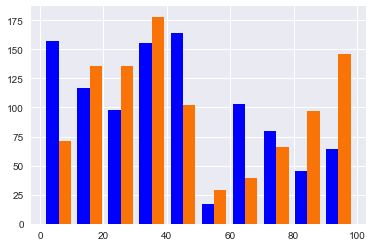

In [27]:
plt.hist([workblue_fair, workorange_fair], color=['b', 'xkcd:orange'])
plt.show()

In [28]:
loans_b = workblue < x_unfair[0]
true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(workblue_defaults))
false_positives_b = np.logical_and(np.logical_not(loans_b), workblue_defaults)


loans_o = workorange < x_unfair[1]
true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(workorange_defaults))
false_positives_o = np.logical_and(np.logical_not(loans_o), workorange_defaults)

In [29]:
workblue_unfair = np.copy(workblue)
workorange_unfair = np.copy(workorange)

workblue_unfair[true_positives_b] +=10
workblue_unfair[false_positives_b] -=20
workblue_unfair[workblue_unfair<1] = 1
workblue_unfair[workblue_unfair>99] = 99

workorange_unfair[true_positives_o] +=10
workorange_unfair[false_positives_o] -=20
workorange_unfair[workorange_unfair<1] = 1
workorange_unfair[workorange_unfair>99] = 99

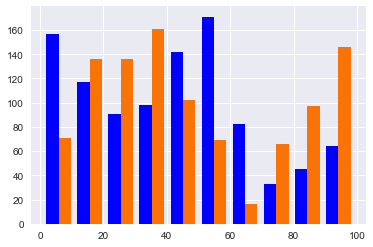

In [30]:
plt.hist([workblue_unfair, workorange_unfair], color=['b', 'xkcd:orange'])
plt.show()

In [31]:
print(sum(workblue_unfair<50), sum(workblue_fair<50))

605 691


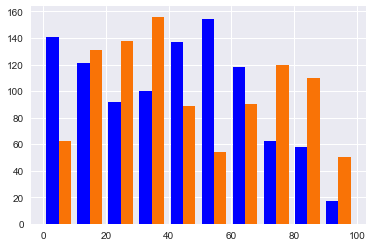

In [32]:
plt.hist([population_log_blues[168], population_log_oranges[168]], color=['b', 'xkcd:orange'])
plt.show()

In [33]:
sum(credit_changes_blue["average distance"] < 0)

1

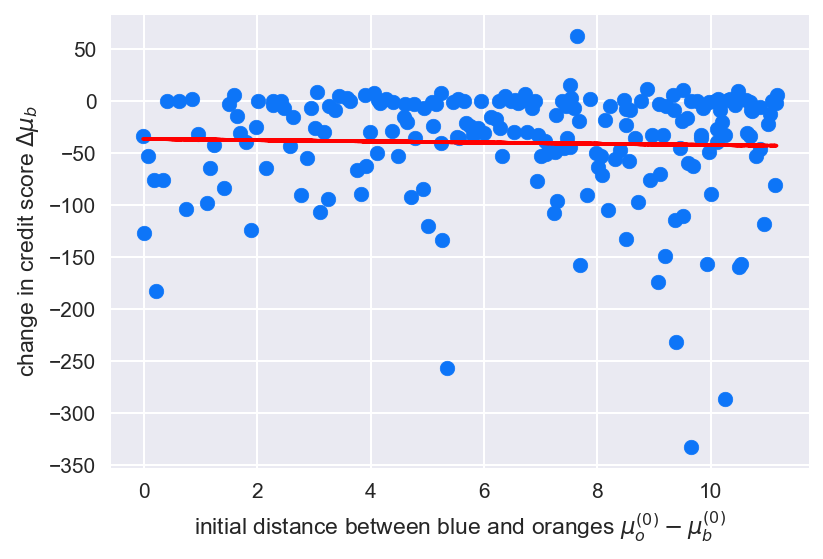

In [45]:
credit_changes_blue_sub = credit_changes_blue.sample(200)

trendline = np.polyfit(credit_changes_blue_sub["average distance"],-credit_changes_blue_sub["distance"], 1)
p = np.poly1d(trendline)

fig, ax = plt.subplots()
fig.set_dpi(150)
ax.scatter(credit_changes_blue_sub["average distance"],-credit_changes_blue_sub["distance"], c='xkcd:deep sky blue')
ax.plot(credit_changes_blue["average distance"], p(credit_changes_blue["average distance"]), "r--")
ax.set_ylabel("change in credit score $\Delta\mu_b$")
ax.set_xlabel("initial distance between blue and oranges $\mu^{(0)}_o - \mu^{(0)}_b$")
plt.savefig("plots/big_sim/GOOD_eq_opt_worse_doesnt_help.pdf")
plt.show()

In [35]:
print(linregress(credit_changes_blue_sub["average distance"],-credit_changes_blue_sub["distance"]))

LinregressResult(slope=-0.5790293999430556, intercept=-36.46311877290242, rvalue=-0.03305116333003698, pvalue=0.6422098879597617, stderr=1.2443539567925113)


In [36]:
credit_changes_blue.tail()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
181,292.0,282.0,10.480,-10.0,195
154,262.0,251.0,9.515,-11.0,196
139,85.0,73.0,8.880,-12.0,197
113,198.0,183.0,7.520,-15.0,198
116,187.0,124.0,7.635,-63.0,199


In [37]:
print(credit_changes_blue.index[-2])
distance_far = 0
distance_close = 0
distance_medium = 0
for i in range(20):
    index = credit_changes_blue.index[i]
    distance_far += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])

for i in range(20):
    index = credit_changes_blue.index[-i]
    distance_close += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
    
    
for i in range(20):
    index = credit_changes_blue.index[i+100]
    distance_medium +=np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
print("far=",distance_far/20, "|| close=",distance_close/20, "|| medium=", distance_medium/20)

113
far= 18.776249999999997 || close= 7.309549999999999 || medium= 11.717000000000002


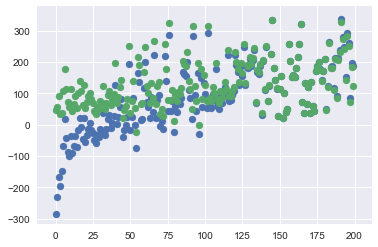

41


In [38]:
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with equal opportunity"])
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with no constraints"])
plt.show()
print(sum(credit_changes_blue["blue with equal opportunity"] < 0))

In [39]:
print(sum(credit_changes_blue["blue with equal opportunity"] - credit_changes_blue["blue with no constraints"] < 0))

153


In [40]:
stats = credit_changes_blue["blue with equal opportunity"] - credit_changes_blue["blue with no constraints"]

In [41]:
print(sum(stats < -1))
print(sum(stats > 1))
print(len(stats))

148
23
200


In [42]:
print(sum(credit_changes_blue['distance'] < 0))

28


In [43]:
print(sum(credit_changes_blue["distance"] > 1))
print(sum(credit_changes_blue["distance"] < -1))

small = credit_changes_blue["distance"] <= 1
butbig = credit_changes_blue["distance"] >= -1
medium = np.logical_and(small, butbig)
print(sum(medium))

148
23
29


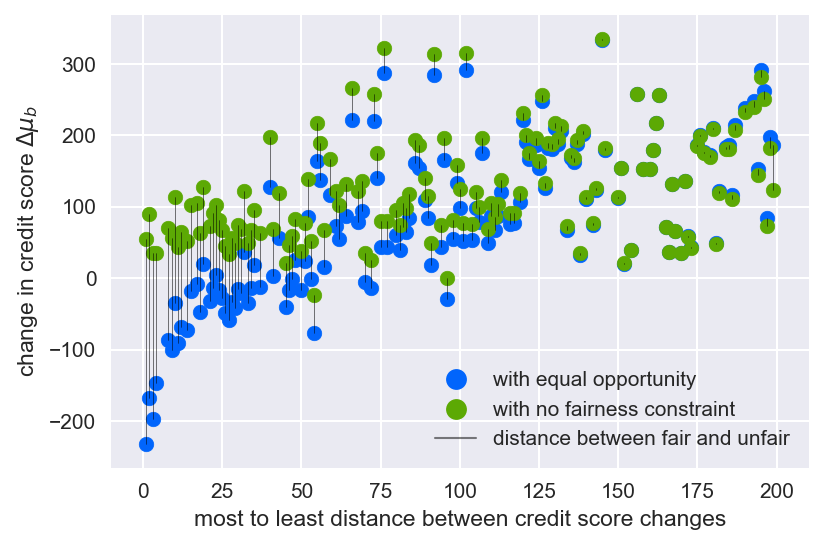

In [44]:
subsampled_credit_changes = credit_changes_blue.sample(150)

average_no_fairness = np.average(subsampled_credit_changes["blue with no constraints"])
average_eq_opt = np.average(subsampled_credit_changes["blue with equal opportunity"])


legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='with equal opportunity',
                          markerfacecolor='xkcd:bright blue', markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='with no fairness constraint',
                          markerfacecolor='xkcd:leaf green', markersize=10),
                   Line2D([0], [0], label='distance between fair and unfair', 
                          color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()

fig.set_dpi(150)

# plt.legend(["with equal opportunity", "with no fairness constraint"])
           
for i in range(len(subsampled_credit_changes.values)):
    ax.plot(subsampled_credit_changes['sorted index'].values[i]*np.ones((2, 1)),
                             [subsampled_credit_changes['blue with equal opportunity'].values[i], 
                              subsampled_credit_changes['blue with no constraints'].values[i]], 
                             c='black', linewidth=0.25)

ax.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"], 
            c="xkcd:bright blue")
ax.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with no constraints"], 
            c='xkcd:leaf green')


ax.set_ylabel("change in credit score $\Delta\mu_b$")
ax.set_xlabel("most to least distance between credit score changes")
ax.legend(handles = legend_elements, loc='best')
plt.savefig("plots/big_sim/eq_opt_distance_between_score_changes.pdf")
plt.show()